# Gradient Descent

Gradient descent constitutes the core of training algorithms in machine learning and deep
learning. In essence, it is an iterative procedure that adjusts model parameters in the
direction opposite to the gradient of the cost function, with the objective of minimizing
said function. This section first presents a purely numerical example in two dimensions,
to visualize descent trajectories, and then several practical examples in PyTorch that
show how the gradient is used to learn the parameters of simple models.

## Example 1: Gradient Descent in a Two-Dimensional Landscape

In this first example, a nonlinear function of two variables is defined and its gradients
are calculated analytically. From several random initial points, gradient descent is
applied and the trajectories are visualized in the parameter plane, which provides a
geometric idea of the optimization process.

The function considered is:

$$
f(x_1, x_2) = \sin(x_1)\cos(x_2) + \sin(0.5\, x_1)\cos(0.5\, x_2),
$$

implemented in NumPy as:

In [1]:
# 3pps
import matplotlib.pyplot as plt
import numpy as np


# Function definition
def function(input: np.ndarray) -> np.ndarray:
    assert input.shape[-1] == 2, "The input must contain 2 elements"
    return np.sin(input[:, 0]) * np.cos(input[:, 1]) + np.sin(
        0.5 * input[:, 0]
    ) * np.cos(0.5 * input[:, 1])

Next, the partial derivatives are defined analytically, that is, the gradient
$\nabla
f(x_1, x_2) = (\partial f/\partial x_1, \partial f/\partial x_2)$:

In [2]:
# Gradient calculation (partial derivatives)


def gradiente(input: np.ndarray) -> np.ndarray:
    assert input.shape[-1] == 2, "The input must contain 2 elements"

    df_x1 = np.cos(input[:, 0]) * np.cos(input[:, 1]) + 0.5 * np.cos(
        0.5 * input[:, 0]
    ) * np.cos(0.5 * input[:, 1])
    df_x2 = -np.sin(input[:, 0]) * np.sin(input[:, 1]) - 0.5 * np.sin(
        0.5 * input[:, 0]
    ) * np.sin(0.5 * input[:, 1])

    return np.stack([df_x1, df_x2], axis=1)

The gradient descent algorithm is implemented as:

In [3]:
# Gradient descent algorithm


def descenso_gradiente(
    num_puntos: int = 10,
    num_iteraciones: int = 30,
    learning_rate: float = 1e-3,
):
    dim = 2
    # Random initialization in the domain [0, 10] x [0, 10]
    X = np.random.rand(num_puntos, dim) * 10
    trayectorias = [X.copy()]

    for _ in range(num_iteraciones):
        X = X - learning_rate * gradiente(input=X)
        trayectorias.append(X.copy())

    return np.array(trayectorias)

The algorithm is executed for several initial points and their trajectories are plotted
in the $(x_1, x_2)$ plane:

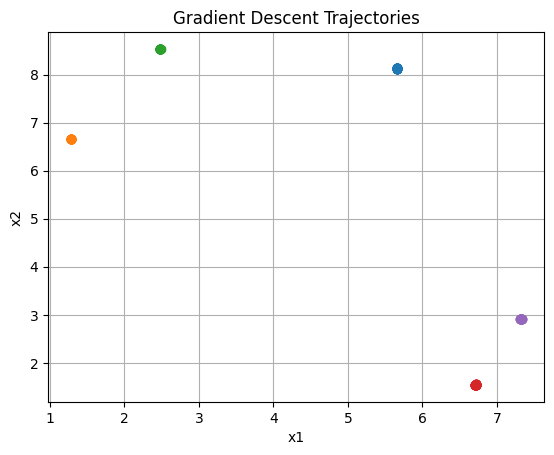

In [4]:
# Execute gradient descent
trayectoria = descenso_gradiente(num_puntos=5, num_iteraciones=30)

# Visualize trajectories in 2D plane
for i in range(trayectoria.shape[1]):
    plt.plot(trayectoria[:, i, 0], trayectoria[:, i, 1], marker="o")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Gradient Descent Trajectories")
plt.grid()
plt.show()

Each curve shows how a point moves iteratively in the descent direction of $f$. This
example visually illustrates the fundamental idea: the gradient indicates the direction
of maximum increase, and the algorithm moves in the opposite direction to approach
function minima.

## Example 2: Fitting a Quadratic Function in PyTorch

In the second example, it is shown how to apply gradient descent in PyTorch to fit a
quadratic function to synthetically generated data. A relationship between time and
velocity is simulated that approximately follows a parabola, with added noise:

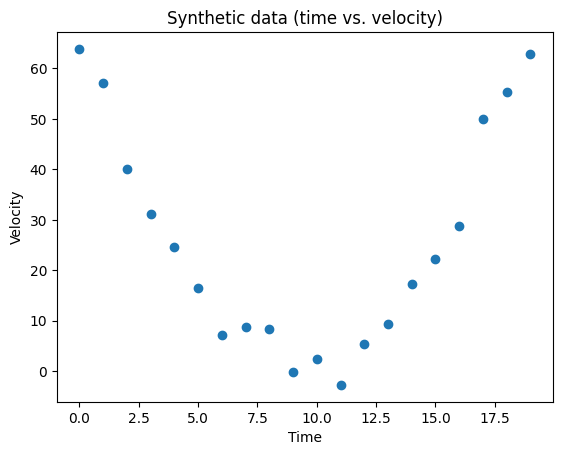

(torch.Size([20]), torch.Size([20]))

In [5]:
# 3pps
import matplotlib.pyplot as plt
import torch


# Synthetic data
tiempo = torch.arange(0, 20).float()
velocidad = torch.randn(20) * 3 + 0.75 * (tiempo - 9.5) ** 2 + 1

plt.scatter(tiempo, velocidad)
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Synthetic data (time vs. velocity)")
plt.show()

velocidad.shape, tiempo.shape

The assumed model is a quadratic function of the form

$$\hat{v}(t) = a t^2 + b t + c, $$

where $(a, b, c)$ are learnable parameters:

In [6]:
def funcion(instante_tiempo: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    a, b, c = parameters
    return a * (instante_tiempo**2) + b * instante_tiempo + c


def loss_function(predicted: torch.Tensor, real: torch.Tensor) -> torch.Tensor:
    return (real - predicted).square().mean()

Parameters are initialized randomly and the initial prediction is observed:

In [7]:
parameters = torch.randn(3, requires_grad=True)
parameters

predicciones = funcion(instante_tiempo=tiempo, parameters=parameters)
predicciones

tensor([ 0.8809,  0.6263,  0.3879,  0.1658, -0.0402, -0.2300, -0.4036, -0.5609,
        -0.7021, -0.8271, -0.9359, -1.0284, -1.1048, -1.1650, -1.2090, -1.2368,
        -1.2483, -1.2437, -1.2229, -1.1859], grad_fn=<AddBackward0>)

To visualize the fit, an auxiliary function is defined:

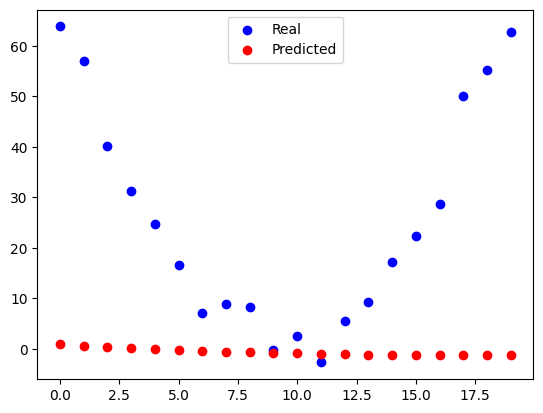

In [8]:
def show_preds(tiempo, real, preds: torch.Tensor):
    plt.scatter(tiempo, real, color="blue", label="Real")
    plt.scatter(
        tiempo,
        preds.detach().cpu().numpy(),
        color="red",
        label="Predicted",
    )
    plt.legend()
    plt.show()


show_preds(tiempo, velocidad, predicciones)

The initial loss is calculated as:

In [9]:
perdida = loss_function(predicciones, velocidad)
perdida

tensor(1134.9524, grad_fn=<MeanBackward0>)

Next, a manual gradient descent step is applied: the gradient is calculated using
`backward()`, parameters are updated, and gradients are reset:

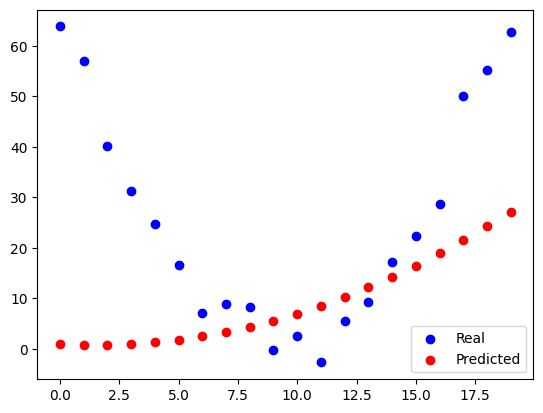

In [10]:
# Calculate gradients
perdida.backward()
parameters.grad

# Gradient descent step
lr = 1e-5
parameters.data = parameters.data - lr * parameters.grad.data
parameters.grad = None

# New prediction after update
predicciones = funcion(instante_tiempo=tiempo, parameters=parameters)
show_preds(tiempo, velocidad, predicciones)

To repeat this process systematically, it is encapsulated in a function:

In [11]:
def apply_step_training(
    tiempo,
    parametros_aprendibles,
    datos_a_predecir,
    lr: float = 1e-5,
):
    predicciones = funcion(instante_tiempo=tiempo, parameters=parametros_aprendibles)
    perdida = loss_function(predicted=predicciones, real=datos_a_predecir)
    perdida.backward()

    # Update parameters without gradient tracking
    with torch.no_grad():
        parametros_aprendibles -= lr * parametros_aprendibles.grad

    # Reset gradients
    parametros_aprendibles.grad.zero_()

    show_preds(tiempo, datos_a_predecir, predicciones)
    return predicciones, parametros_aprendibles, perdida

Training is executed for several epochs:

  0%|          | 0/20 [00:00<?, ?it/s]

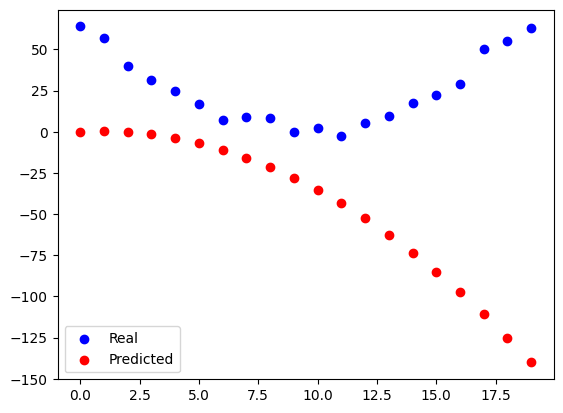

  5%|▌         | 1/20 [00:00<00:02,  7.70it/s]

Epoch 1, loss: 8042.47412109375


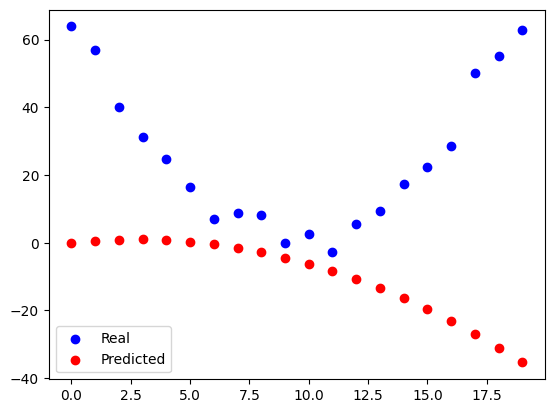

 10%|█         | 2/20 [00:00<00:02,  8.35it/s]

Epoch 2, loss: 2017.806396484375


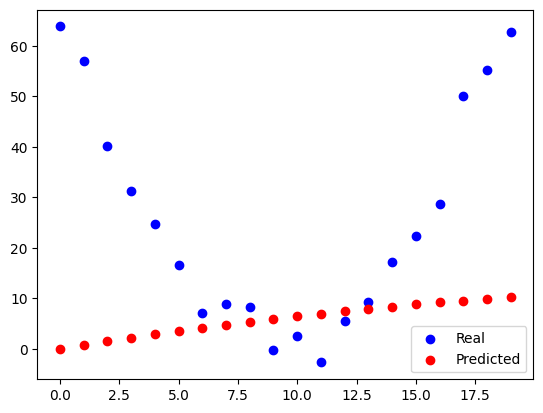

 15%|█▌        | 3/20 [00:00<00:02,  7.67it/s]

Epoch 3, loss: 877.7517700195312


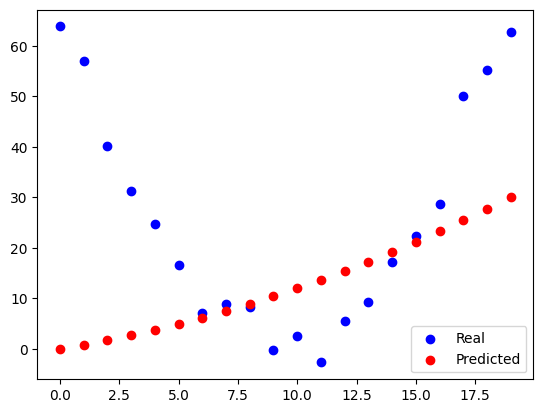

Epoch 4, loss: 662.01513671875


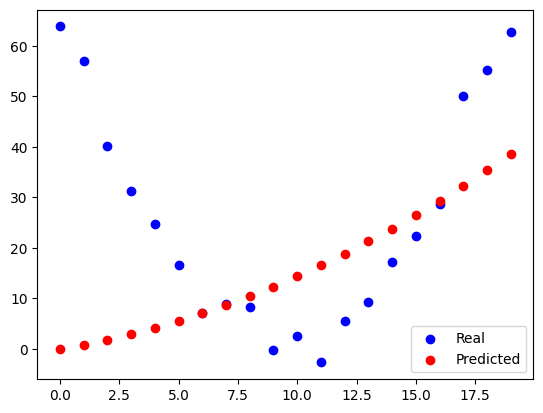

 25%|██▌       | 5/20 [00:00<00:02,  7.28it/s]

Epoch 5, loss: 621.1880493164062


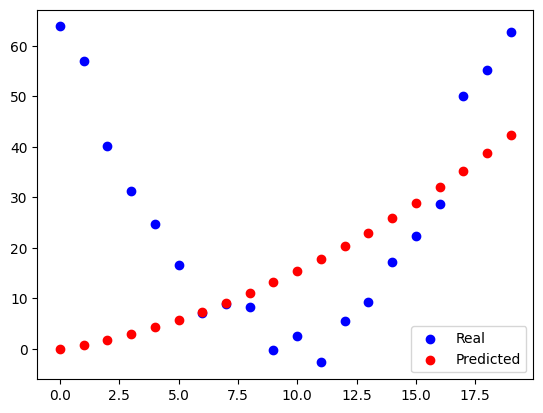

 30%|███       | 6/20 [00:00<00:01,  7.46it/s]

Epoch 6, loss: 613.4591064453125


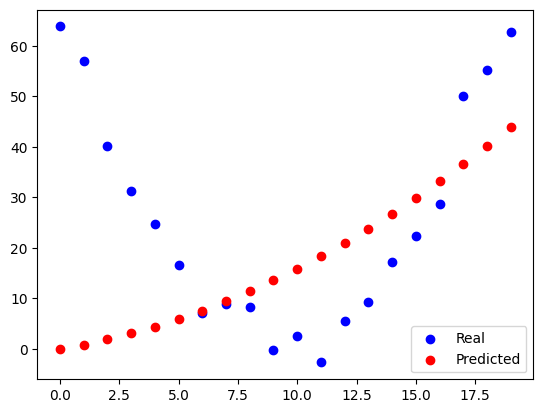

Epoch 7, loss: 611.9932250976562


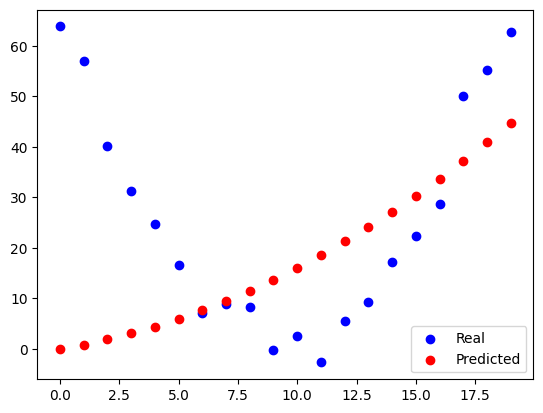

 40%|████      | 8/20 [00:00<00:01,  8.81it/s]

Epoch 8, loss: 611.7125854492188


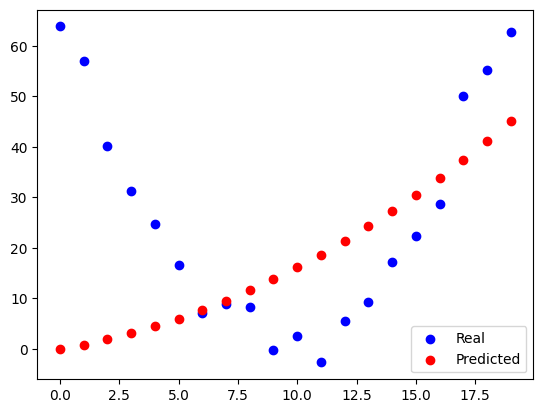

 45%|████▌     | 9/20 [00:01<00:01,  8.92it/s]

Epoch 9, loss: 611.65625


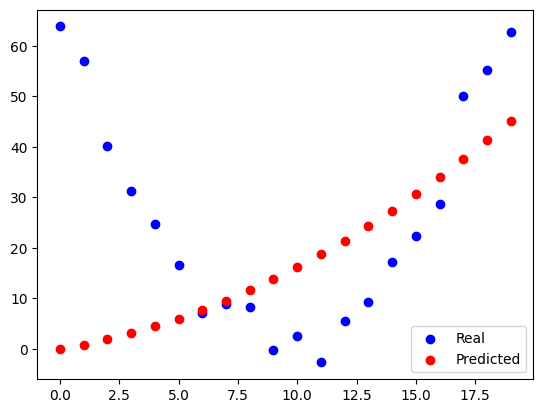

Epoch 10, loss: 611.642333984375


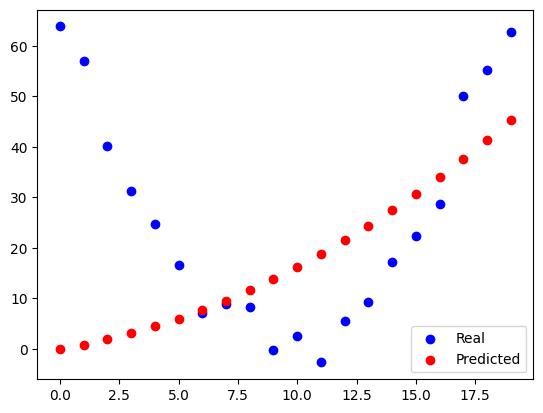

 55%|█████▌    | 11/20 [00:01<00:00,  9.86it/s]

Epoch 11, loss: 611.6364135742188


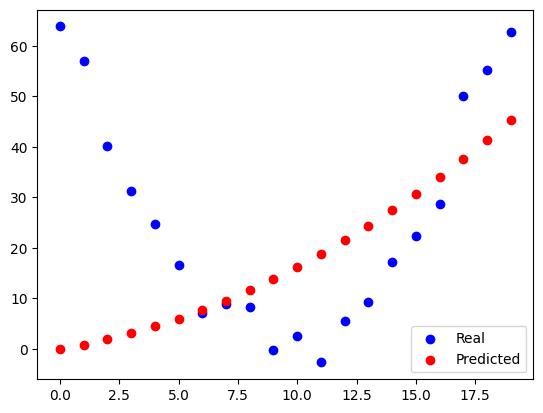

Epoch 12, loss: 611.6319580078125


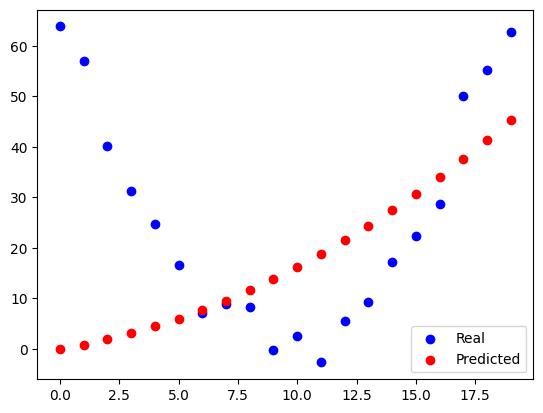

 65%|██████▌   | 13/20 [00:01<00:00, 10.06it/s]

Epoch 13, loss: 611.6279296875


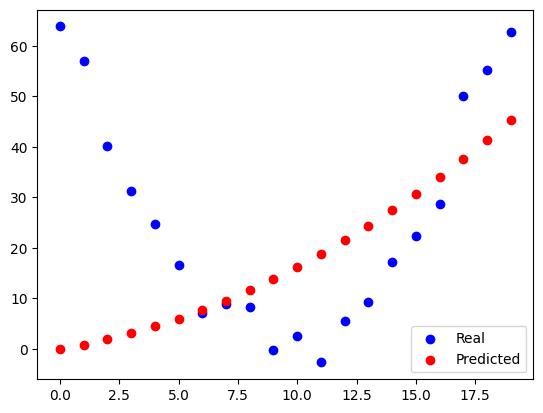

Epoch 14, loss: 611.6239013671875


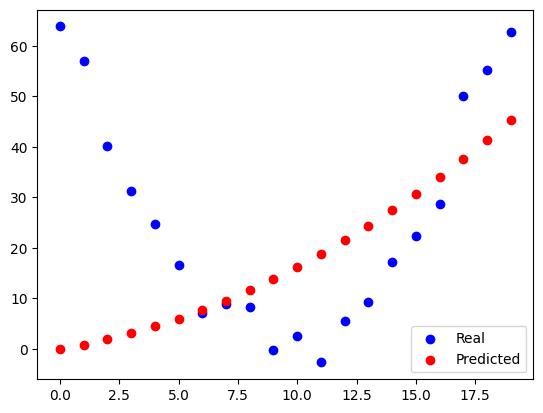

 75%|███████▌  | 15/20 [00:01<00:00,  9.78it/s]

Epoch 15, loss: 611.619873046875


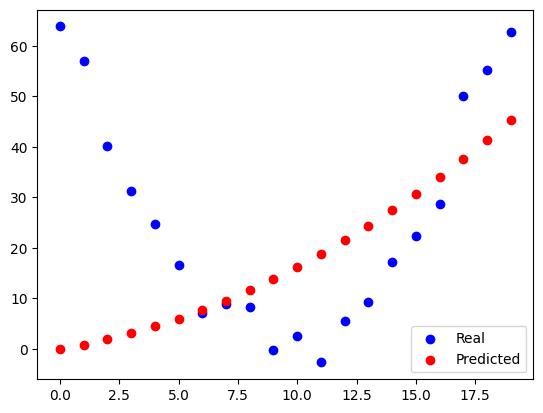

 80%|████████  | 16/20 [00:01<00:00,  8.06it/s]

Epoch 16, loss: 611.6158447265625


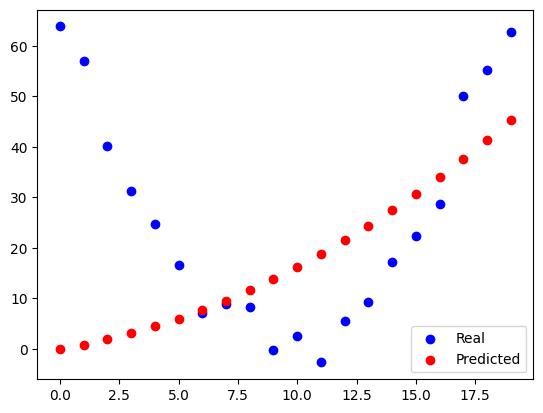

 85%|████████▌ | 17/20 [00:02<00:00,  7.96it/s]

Epoch 17, loss: 611.6119384765625


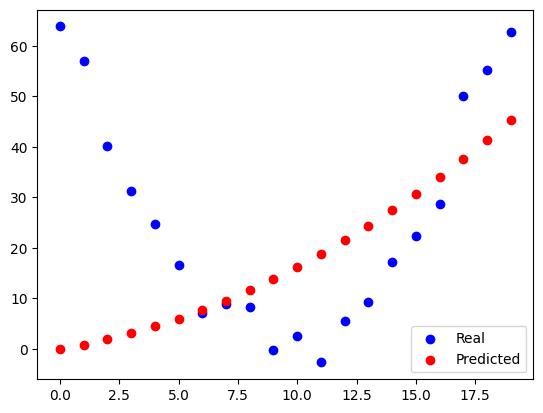

 90%|█████████ | 18/20 [00:02<00:00,  7.73it/s]

Epoch 18, loss: 611.6078491210938


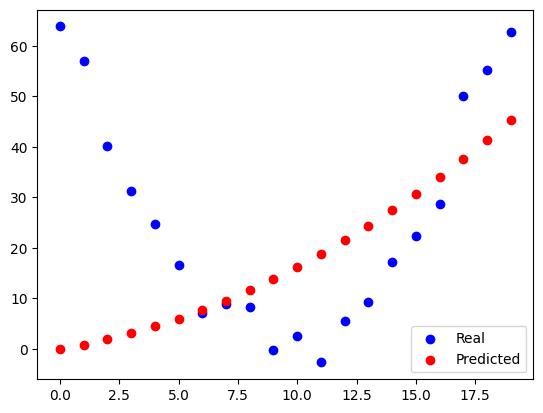

 95%|█████████▌| 19/20 [00:02<00:00,  6.05it/s]

Epoch 19, loss: 611.6038208007812


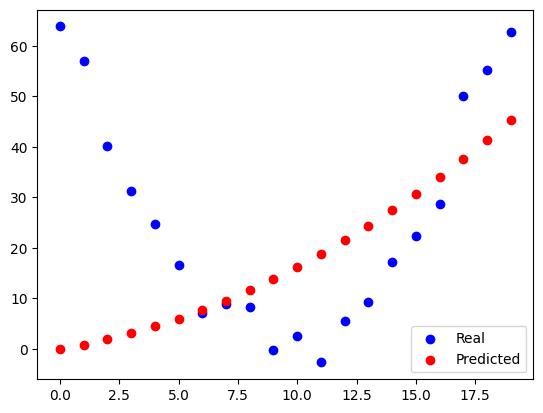

100%|██████████| 20/20 [00:02<00:00,  7.29it/s]

Epoch 20, loss: 611.599853515625


In [12]:
# 3pps
from tqdm import tqdm


num_epochs = 20
parametros_aprendibles = torch.randn(3, requires_grad=True)

for epoch in tqdm(range(num_epochs)):
    predicciones, parametros_aprendibles, perdida = apply_step_training(
        tiempo=tiempo,
        parametros_aprendibles=parametros_aprendibles,
        datos_a_predecir=velocidad,
    )
    print(f"Epoch {epoch+1}, loss: {perdida}")

This flow illustrates the key training components in PyTorch:

- Definition of a differentiable function.
- Loss calculation.
- Call to `backward()` to obtain gradients.
- Manual parameter update within a `torch.no_grad()` context.
- Gradient reset before the next iteration.

## Example 3: Manually Implemented Linear Layer and Simple Linear Module

In this part, two complementary ideas are introduced: the abstraction of a linear layer
and the implementation of a linear model in PyTorch as a subclass of `nn.Module`.

First, a function that would represent a linear layer applied to an input is sketched:

In [13]:
def linear_layer(tensor_entrada: torch.Tensor) -> torch.Tensor:
    # tensor_entrada: (B, N)
    # w: (N,)
    # b: scalar
    return tensor_entrada @ w + b

And a minimalist class:

In [14]:
class CapaLineal:
    def __init__(self, shape_entrada: int) -> None:
        self.w = torch.randn()

Although this is just a sketch, it serves to connect with PyTorch's standard
implementation using `nn.Module`. Next, a fully functional linear model is proposed:

In [15]:
# 3pps
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch import nn


class Linear(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.bias = nn.Parameter(data=torch.rand(1), requires_grad=True)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.weight * input_tensor + self.bias

The available device is checked:

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Synthetic data following a linear relationship is generated:

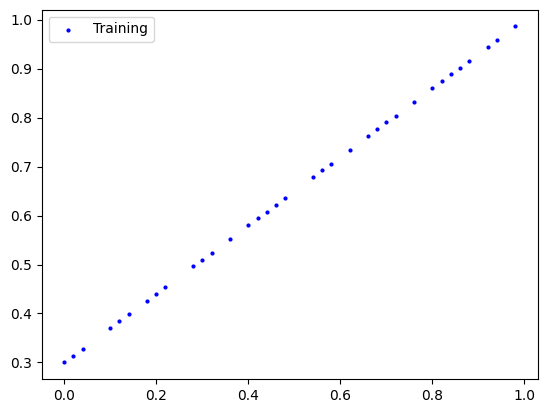

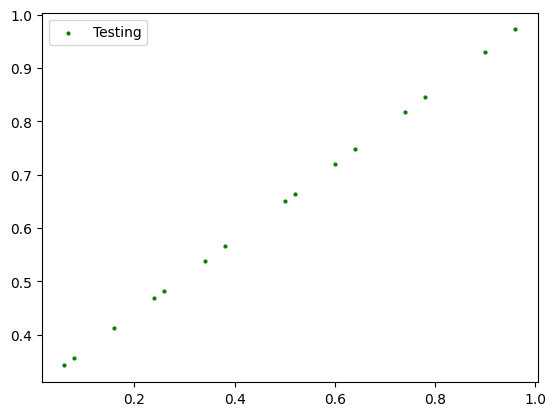

In [17]:
start = 0
end = 1
steps = 0.02
X = np.arange(start, end, steps)

bias = 0.3
weight = 0.7
y = weight * X + bias

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

plt.scatter(X_train, y_train, c="b", s=4, label="Training")
plt.legend()
plt.show()

plt.scatter(X_test, y_test, c="g", s=4, label="Testing")
plt.legend()
plt.show()

The model is initialized and its parameters are inspected:

In [18]:
linear_model = Linear()
list(linear_model.parameters())
linear_model.state_dict()

OrderedDict([('weight', tensor([0.4947])), ('bias', tensor([0.3448]))])

Before training, the model is evaluated on the test set:

In [19]:
linear_model.eval()
with torch.no_grad():
    predictions = linear_model(X_test)

predictions

tensor([0.4735, 0.7307, 0.6417, 0.7901, 0.5130, 0.8198, 0.6021, 0.5922, 0.6615,
        0.5328, 0.4636, 0.3844, 0.7109, 0.4240, 0.3745])

Here an important distinction is introduced: `torch.no_grad()` and
`torch.inference_mode()`. From PyTorch's documentation:

- `no_grad` disables gradient tracking during the block, which avoids storing information
  for autograd.
- `inference_mode` is analogous to `no_grad` but more strict and efficient: it also
  disables view tracking and version counting, and ensures that tensors created in this
  context are not subsequently used in computations with autograd.

In practice, `inference_mode` is recommended for inference code, where it is known that
the model will not be trained or updated. This reduces overhead and increases safety
against accidental parameter modifications:

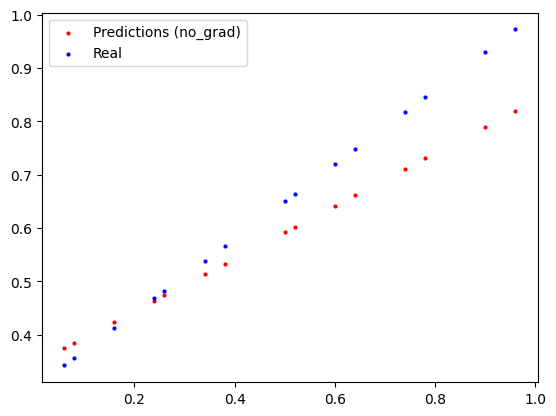

In [20]:
with torch.inference_mode():
    predictions_2 = linear_model(X_test)

predictions_2

plt.scatter(X_test, predictions, c="r", s=4, label="Predictions (no_grad)")
plt.scatter(X_test, y_test, c="b", s=4, label="Real")
plt.legend()
plt.show()

A loss function and optimizer based on PyTorch are defined:

In [21]:
loss_fn = nn.L1Loss()  # Mean absolute error
optimizer = torch.optim.SGD(linear_model.parameters())

Next, the model is trained for several epochs, iterating over training data and
evaluating on test data:

In [22]:
num_epochs: int = 50

for epoch in range(num_epochs):
    epoch_losses_train = []
    epoch_losses_test = []

    # Training phase
    linear_model.train()
    for x, y_true in zip(X_train, y_train):
        optimizer.zero_grad()

        output_model = linear_model(x)
        loss = loss_fn(output_model, y_true)

        loss.backward()
        optimizer.step()

        epoch_losses_train.append(loss.item())

    # Evaluation phase
    linear_model.eval()
    with torch.inference_mode():
        for x, y_true in zip(X_test, y_test):
            output_model = linear_model(x)
            loss = loss_fn(output_model, y_true)
            epoch_losses_test.append(loss.item())

    print(
        f"Epoch: {epoch+1}, "
        f"Train Loss: {np.mean(epoch_losses_train):.4f}, "
        f"Test Loss: {np.mean(epoch_losses_test):.4f}"
    )

/home/dani/Repositorios/unie-deep-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 1, Train Loss: 0.0616, Test Loss: 0.0507
Epoch: 2, Train Loss: 0.0506, Test Loss: 0.0439
Epoch: 3, Train Loss: 0.0449, Test Loss: 0.0409
Epoch: 4, Train Loss: 0.0418, Test Loss: 0.0383
Epoch: 5, Train Loss: 0.0393, Test Loss: 0.0359
Epoch: 6, Train Loss: 0.0373, Test Loss: 0.0344
Epoch: 7, Train Loss: 0.0354, Test Loss: 0.0327
Epoch: 8, Train Loss: 0.0336, Test Loss: 0.0311
Epoch: 9, Train Loss: 0.0318, Test Loss: 0.0295
Epoch: 10, Train Loss: 0.0300, Test Loss: 0.0279
Epoch: 11, Train Loss: 0.0282, Test Loss: 0.0263
Epoch: 12, Train Loss: 0.0264, Test Loss: 0.0244
Epoch: 13, Train Loss: 0.0247, Test Loss: 0.0228
Epoch: 14, Train Loss: 0.0229, Test Loss: 0.0210
Epoch: 15, Train Loss: 0.0213, Test Loss: 0.0194
Epoch: 16, Train Loss: 0.0194, Test Loss: 0.0175
Epoch: 17, Train Loss: 0.0178, Test Loss: 0.0159
Epoch: 18, Train Loss: 0.0159, Test Loss: 0.0141
Epoch: 19, Train Loss: 0.0143, Test Loss: 0.0124
Epoch: 20, Train Loss: 0.0124, Test Loss: 0.0106
Epoch: 21, Train Loss: 0.0108

After training, final predictions are compared with real data:

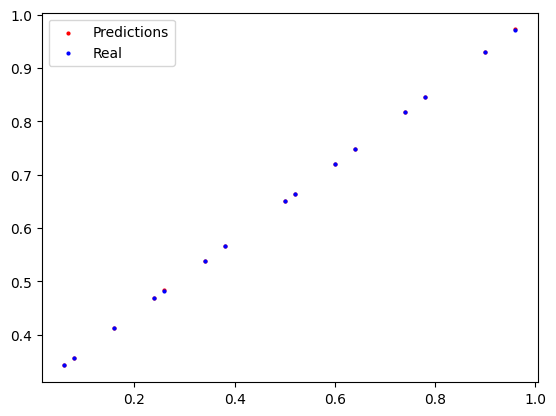

In [23]:
with torch.inference_mode():
    predictions_trained = linear_model(X_test)

plt.scatter(X_test, predictions_trained, c="r", s=4, label="Predictions")
plt.scatter(X_test, y_test, c="b", s=4, label="Real")
plt.legend()
plt.show()

Finally, it is illustrated how to save and load the trained model:

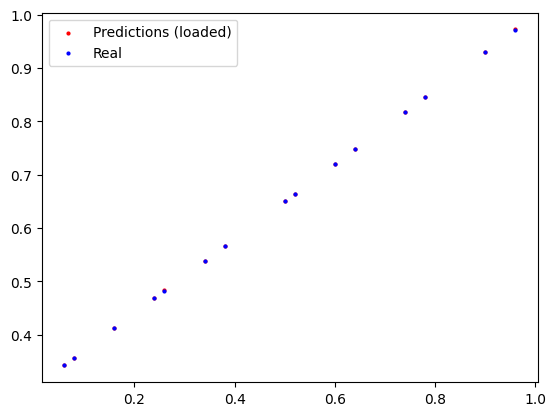

In [24]:
# Save only the state dict
torch.save(linear_model.state_dict(), "linear_model_state.pth")

# Load the state dict
linear_model_loaded = Linear()  # Create a new instance
linear_model_loaded.load_state_dict(
    torch.load("linear_model_state.pth", weights_only=True)
)
linear_model_loaded.eval()

with torch.inference_mode():
    predictions_loaded = linear_model_loaded(X_test)

plt.scatter(X_test, predictions_loaded, c="r", s=4, label="Predictions (loaded)")
plt.scatter(X_test, y_test, c="b", s=4, label="Real")
plt.legend()
plt.show()